In [19]:
import skimage as ski
#import pydicom
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
import math
import ipywidgets


In [20]:
def load_img(filename):
    image = ski.io.imread(filename, as_gray=True)
    image = ski.img_as_float(image)
    return image

In [21]:
def normalize(image):
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    image = image * 255
    return image

In [22]:
def bresenham(x1,y1, x2, y2):
    points = []
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    while True:
        points.append((x1, y1))
        if x1 == x2 and y1 == y2:
            break
        err2 = err * 2
        if err2 > -dy:
            err -= dy
            x1 += sx
        if err2 < dx:
            err += dx
            y1 += sy

    return points


In [23]:
def prepare_square(image):
    rows, cols = image.shape

    if rows == cols:
        return image

    longer_side = max(rows, cols)
    padded_image = np.zeros((longer_side, longer_side), dtype=image.dtype)
    start_row = (longer_side - rows) // 2
    start_col = (longer_side - cols) // 2

    padded_image[start_row:start_row + rows, start_col:start_col + cols] = image


    return padded_image

In [24]:
def radon_transform(image, angle=360, detectors=180, scans=360, angle_of_cone=90):  #scans = steps, angle = rotation angle
    sinogram_steps = []
    # image = prepare_square(input_image)
    rows, cols = image.shape
    center_y = rows // 2
    center_x = cols // 2

    emiters_positions = []

    radius = np.sqrt(2) * max(center_x, center_y)

    sinogram = np.zeros((scans, detectors), dtype=image.dtype)
    delta_alpha = angle / scans
    for iteration in range(scans):
        alpha = iteration * delta_alpha
        x_e = int(center_x + radius * math.cos(math.radians(alpha)))
        y_e = int(center_y + radius * math.sin(math.radians(alpha)))
        emiters_positions.append((x_e, y_e))

        for i in range(detectors):  # i as a detector number
            x_di = int(center_x + radius * math.cos(math.radians(alpha + 180 - angle_of_cone + i * 2 * angle_of_cone / (detectors - 1))))
            y_di = int(center_y + radius * math.sin(math.radians(alpha + 180 - angle_of_cone + i * 2 * angle_of_cone / (detectors - 1))))

            points = bresenham(x_e, y_e, x_di, y_di)

            total_intensity = 0
            valid_points_count = 0
            for x_b, y_b in points:
                if 0 <= y_b < rows and 0 <= x_b < cols:
                    total_intensity += image[y_b, x_b]
                    valid_points_count += 1

            if valid_points_count > 0:
                total_intensity /= valid_points_count
            else:
                total_intensity = 0
            sinogram[iteration, i] = total_intensity
        sinogram_steps.append(sinogram.copy())

    return sinogram, sinogram_steps, emiters_positions


In [25]:
def inverse_radon_transform(sinogram, image_shape, angle=360, angle_of_cone=90):
    steps = []
    scans, detectors = sinogram.shape
    rows, cols = image_shape
    center_y = rows // 2
    center_x = cols // 2
    radius = np.sqrt(2) * max(center_x, center_y)

    delta_alpha = angle / scans
    reconstruction = np.zeros((rows, cols), dtype=np.float32)

    for iteration in range(scans):
        alpha = iteration * delta_alpha
        angle_rad = math.radians(alpha)
        x_e = int(center_x + radius * math.cos(angle_rad))
        y_e = int(center_y + radius * math.sin(angle_rad))

        for i in range(detectors):
            detector_angle = math.radians(alpha + 180 - angle_of_cone + i * 2 * angle_of_cone / (detectors - 1))
            x_d = int(center_x + radius * math.cos(detector_angle))
            y_d = int(center_y + radius * math.sin(detector_angle))


            points = bresenham(x_e, y_e, x_d, y_d)

            value = sinogram[iteration, i]

            for x_b, y_b in points:
                if 0 <= y_b < rows and 0 <= x_b < cols:
                    reconstruction[y_b, x_b] += value
        steps.append(reconstruction.copy())



    return reconstruction, steps

In [26]:
def show_steps(n, steps, name):
    plt.imshow(steps[n-1], cmap='gray')
    plt.title(name + " : Step " + str(n))
    plt.axis("off")
    plt.show()


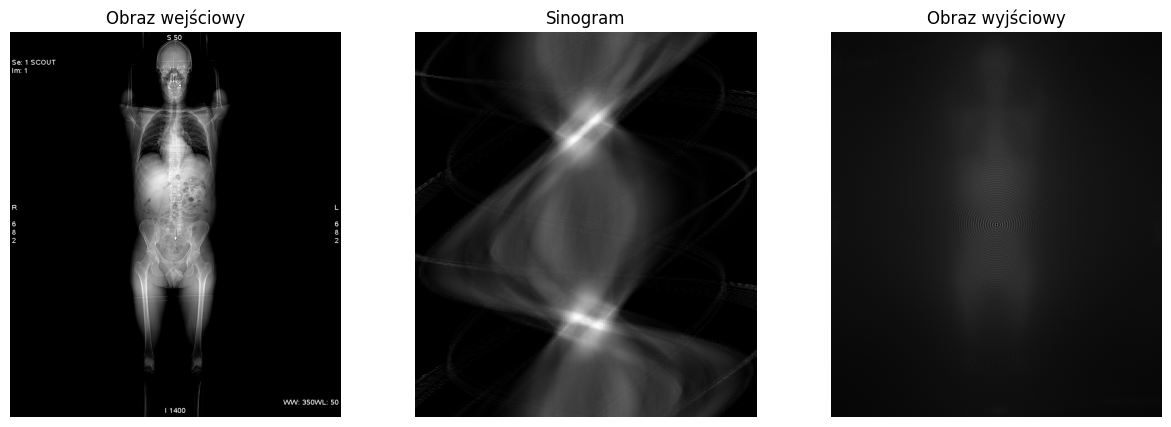

interactive(children=(IntSlider(value=1, description='n', max=360, min=1), Output()), _dom_classes=('widget-in…

interactive(children=(IntSlider(value=1, description='n', max=360, min=1), Output()), _dom_classes=('widget-in…

In [27]:
def main():
    image = load_img("tomograf-obrazy/CT_ScoutView.jpg")
    steps = 360
    detectors = 180
    angle_of_cone = 90

    sinogram, steps_sinogram, emiters = radon_transform(image, steps, detectors, steps, angle_of_cone)
    reversed, steps_inversed = inverse_radon_transform(sinogram, image.shape, steps, angle_of_cone)

    sinogram = normalize(sinogram.copy())
    reversed = normalize(reversed.copy())
    steps_sinogram = [normalize(step.copy()) for step in steps_sinogram]
    steps_inversed = [normalize(step.copy()) for step in steps_inversed]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Obraz wejściowy")
    axes[0].axis("off")
    # if emiters:
    #     xs, ys = zip(*emiters)
    #     axes[0].scatter(xs, ys, c='red', s=10, label='Emiters')

    axes[1].imshow(sinogram, cmap='gray', aspect='auto')
    axes[1].set_title("Sinogram")
    axes[1].axis("off")

    axes[2].imshow(reversed, cmap='gray')
    axes[2].set_title("Obraz wyjściowy")
    axes[2].axis("off")
    plt.show()


    ipywidgets.interact(
        show_steps,
        n=ipywidgets.IntSlider(min=1, max=len(steps_sinogram), step=1, value=1),
        steps=ipywidgets.fixed(steps_sinogram),
        name=ipywidgets.fixed("Sinogram Steps")
    )

    ipywidgets.interact(
        show_steps,
        n=ipywidgets.IntSlider(min=1, max=len(steps_inversed), step=1, value=1),
        steps=ipywidgets.fixed(steps_inversed),
        name=ipywidgets.fixed("Reconstruction Steps")
    )
main()

